In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


%matplotlib inline

In [28]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [29]:
mu0 = torch.zeros(2)
mu1 = torch.Tensor([2, 2])
d0 = torch.distributions.MultivariateNormal(mu0, torch.eye(2))
d1 = torch.distributions.MultivariateNormal(mu1, torch.eye(2))
print(d0.sample((5,)))
print(d1.sample((5,)))

tensor([[-0.1893,  1.0030],
        [ 0.3196, -0.8307],
        [ 0.3550, -0.2788],
        [ 1.1049, -0.0862],
        [ 0.3959, -0.0656]])
tensor([[ 1.0842,  1.3791],
        [ 1.7246, -0.5894],
        [ 3.2105,  4.1778],
        [ 0.6473,  3.7816],
        [ 0.0945,  2.3377]])


In [30]:
net = nn.Sequential(nn.Linear(2, 5), nn.ReLU(), nn.Linear(5, 1))
for p in net.parameters():
    print(p.data)
net_opt = optim.SGD(lr=1e-3, params=list(net.parameters()))

tensor([[ 0.5377,  0.5408],
        [ 0.0841,  0.1652],
        [-0.2081, -0.0708],
        [ 0.5239,  0.5974],
        [-0.4292,  0.6057]])
tensor([-0.6641, -0.4664, -0.4822,  0.1079, -0.5010])
tensor([[ 0.0750, -0.0746,  0.1399,  0.1186, -0.1152]])
tensor([ 0.3097])


In [36]:
log_freq = 500
for i in range(20000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = F.sigmoid(net(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    net_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    
#     out = F.sigmoid(layer(x))
#     loss = F.binary_cross_entropy(out, y)
    
    out = net(x)
    loss = F.binary_cross_entropy_with_logits(out, y)
    
    loss.backward()
    net_opt.step()

Ошибка после 0 итераций: 0.218263
Ошибка после 1 итераций: 0.219498
Ошибка после 2 итераций: 0.217282
Ошибка после 3 итераций: 0.218068
Ошибка после 4 итераций: 0.215795
Ошибка после 5 итераций: 0.214777
Ошибка после 6 итераций: 0.216338
Ошибка после 7 итераций: 0.213352
Ошибка после 8 итераций: 0.214667
Ошибка после 9 итераций: 0.214280
Ошибка после 10 итераций: 0.215949
Ошибка после 11 итераций: 0.214921
Ошибка после 12 итераций: 0.213380
Ошибка после 13 итераций: 0.213506
Ошибка после 14 итераций: 0.212646
Ошибка после 15 итераций: 0.212320
Ошибка после 16 итераций: 0.212837
Ошибка после 17 итераций: 0.212841
Ошибка после 18 итераций: 0.213381
Ошибка после 19 итераций: 0.210021
Ошибка после 20 итераций: 0.210523
Ошибка после 21 итераций: 0.210881
Ошибка после 22 итераций: 0.210389
Ошибка после 23 итераций: 0.209793
Ошибка после 24 итераций: 0.208734
Ошибка после 25 итераций: 0.210261
Ошибка после 26 итераций: 0.208747
Ошибка после 27 итераций: 0.209996
Ошибка после 28 итераций: 0.20

In [37]:
net

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

### Картиночки

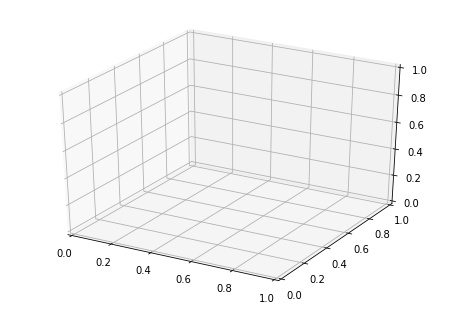

In [38]:
import pylab
from mpl_toolkits.mplot3d import Axes3D

fig = pylab.figure()
Axes3D(fig)

pylab.show()

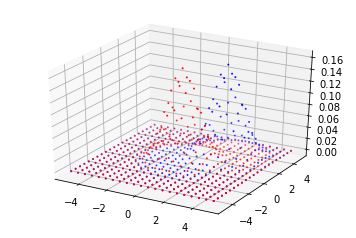

In [47]:
# Сетка
x_scale = np.arange(-5, 5.1, 0.5)
y_scale = np.arange(-5, 5.1, 0.5)
X,Y = np.meshgrid(x_scale,x_scale)
XY=np.array([X.flatten(),Y.flatten()]).T
# формируем распределения(pdf - плотность) на сетке
#?stats.multivariate_normal()
d0_stats = stats.multivariate_normal(mu0,torch.eye(2))
d0_dens = d0_stats.pdf(XY)
d1_stats = stats.multivariate_normal(mu1,torch.eye(2))
d1_dens = d1_stats.pdf(XY)
# Отрисовка
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Распределения(плотности)
ax.scatter(XY[:, 0], XY[:, 1], d0_dens.reshape(-1, 1), color="r", s=1)
ax.scatter(XY[:, 0], XY[:, 1], d1_dens.reshape(-1, 1), color="b", s=1)

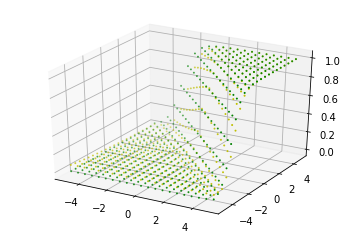

In [48]:
ratio = d1_dens / (d1_dens + d0_dens)
XY_tensor = torch.tensor(XY, dtype=torch.float)
with torch.no_grad():
    dist = F.sigmoid(net(XY_tensor)).numpy()
# Разделяющая поверхность
fig = plt.figure()
ax_2 = fig.add_subplot(111, projection='3d')
ax_2.scatter(XY[:, 0], XY[:, 1], ratio.reshape(-1, 1), color="g", s=1)
ax_2.scatter(XY[:, 0], XY[:, 1], dist.reshape(-1, 1), color="y", s=1)